# Fine Tuning NASNetLarge terhadap dataset Clothing 10.000

Berikut adalah jupyter notebook untuk fine tuning terhadap arsitektur NASNetLarge tersebut supaya bisa digunakan untuk memprediksi dataset Clothing 10.000.

## Clothing 10.000

Clothing 10.000 adalah sebuah dataset yang dikumpulkan oleh penelitin dengan melakukan proses pengumpulan gambar-gambar dari situs e-commerce secara manual. Dataset ini terdiri dari 10 kelas, masing-masing terdiri dari 1.000 data untuk training dan 250 data untuk testing. Total terdiri dari 12.500 data.

## Langkah Fine Tuning

Secara garis besar, berikut adalah langkah fine tuning yang dilakukan pada penelitian ini:
1. Image augmentation untuk data training dan validation
2. Instansiasi arsitektur model asli dari keras, dan menghilangkan top layer-nya
3. Menambahkan beberapa layer untuk menggantikan top layer model
4. Set-up fine tuning
5. Training model
6. Testing model

Berikut langkah-langkah tersebut

In [47]:
import os, sys, glob, datetime, time, pytz

from keras import __version__

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [48]:
# Defining variables
BAT_SIZE      = 20
DATA_SET_DIR  = '/home/jupyter/clothing-dataset/data/' # clothing dataset 10.000

WIDTH, HEIGHT = 331, 331
FC_SIZE       = 256

TRAIN_DIR        = DATA_SET_DIR + 'train'
TEST_DIR         = DATA_SET_DIR + 'test'
nb_classes       = len(glob.glob(TRAIN_DIR + "/*"))

timezone = pytz.timezone("Asia/Jakarta")

now = timezone.localize(datetime.datetime.now())

## 1. Image augmentation untuk data testing

Di bawah ini adalah langkah pertama yang dilakukan.

Found 2500 images belonging to 10 classes.
Testing Sample


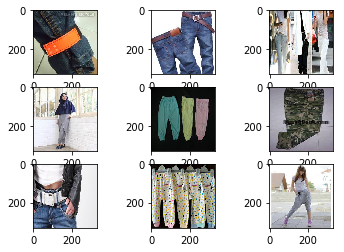

In [49]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    shuffle=False
)

print('Testing Sample')
x,y = test_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

## 2. Testing model

Langkah berikutnya adalah testing menggunakan dataset testing.

Berikut adalah langkahnya

In [50]:
# Testing
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope
from keras.metrics import top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

print('Loading saved model')
with CustomObjectScope({'top_3_accuracy': top_3_accuracy}):
    model = load_model('NASNetLarge.model')

print('Testing...')
testing_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
testing_start = time.time()
Y_pred = model.predict_generator(
    test_generator, 
    steps=test_generator.samples // BAT_SIZE,
    verbose=1
)
testing_end = time.time()
testing_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
print('Testing from %s to %s taking %d seconds.' % (testing_start_datetime, testing_end_datetime, (testing_end - testing_start)))

Loading saved model
Testing...
125/125 [==============================] - 101s 807ms/step
Testing from 2019-07-25 00:45:29 to 2019-07-25 00:47:09 taking 100 seconds.


## Langkah tambahan: Tampilkan accuracy, loss, confusion matrix serta classification report

Langkah ini dilakukan untuk menampilkan kurva accuracy dan loss dari training yang telah dilakukan. Serta confusion matrix untuk testing. Selain itu detail laporan terkait precision, f-score dan recall juga ditampilkan di sini.

Berikut adalah langkahnya

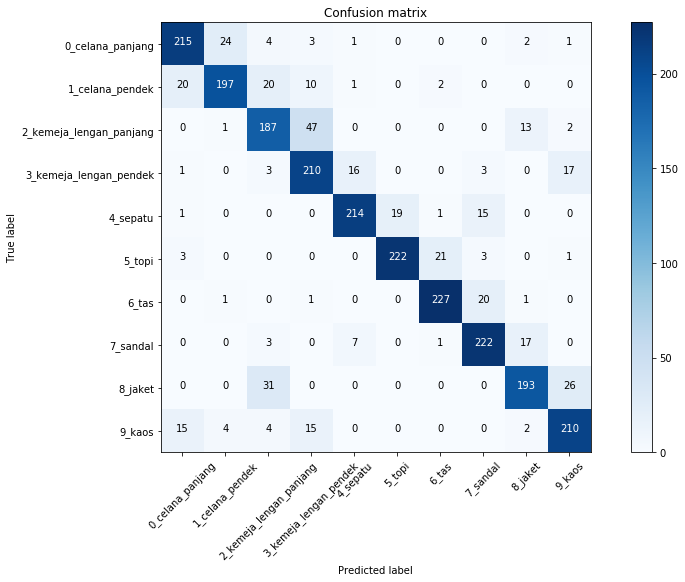

Classification Report
                         precision    recall  f1-score   support

       0_celana_panjang       0.84      0.86      0.85       250
        1_celana_pendek       0.87      0.79      0.83       250
2_kemeja_lengan_panjang       0.74      0.75      0.75       250
 3_kemeja_lengan_pendek       0.73      0.84      0.78       250
               4_sepatu       0.90      0.86      0.88       250
                 5_topi       0.92      0.89      0.90       250
                  6_tas       0.90      0.91      0.90       250
               7_sandal       0.84      0.89      0.87       250
                8_jaket       0.85      0.77      0.81       250
                 9_kaos       0.82      0.84      0.83       250

               accuracy                           0.84      2500
              macro avg       0.84      0.84      0.84      2500
           weighted avg       0.84      0.84      0.84      2500



In [51]:
# %matplotlib inline

# import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
classes = sorted(os.listdir(TEST_DIR))
plt.figure(figsize=(12,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Classification Report')
classification_report = classification_report(test_generator.classes, y_pred, target_names=classes)
print(classification_report)